In [9]:
# !pip install pandas-datareader
# !pip install fix_yahoo_finance
import pandas as pd
import datetime
from datetime import timedelta
import pandas_datareader.data as web
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
class EventStudy():
    def __init__(self,file_path):
        try:
            pd.read_csv(file_path)
        except TypeError:
            return f'Wrong File Type.'
        
        #Define all basic attributes below
        self.dataframe = pd.DataFrame(pd.read_csv(file_path))
        self.company = self.dataframe['Ticker']
        self.market = self.dataframe['Market']
        self.industry = self.dataframe['Industry']
        self.year = self.dataframe['Year']
        self.month = self.dataframe['Month']
        self.day = self.dataframe['Day']
        
        ##Establish the dictionary and lists to store information for further reference
        
        #Store the link between the stock and the market that it belongs to 
        self.dict = {}
        for i in range(0,len(self.market)):
            self.dict[self.company[i]] = self.market[i]
        
        #Store the event dates
        eventdate = []
        for i in range(0,len(self.dataframe)):
            eventdate.append(datetime.datetime(self.year[i],self.month[i],self.day[i]))
        self.dataframe['EventDate'] = eventdate
        
        #Suppose there is only one event in a month to avoid too short sample periods.
        
        inter_days = []
        uniquedays = sorted(self.dataframe['EventDate'].unique())
        for i in range(0,len(uniquedays)-1):
            inter_days.append(int((uniquedays[i+1]-uniquedays[i])/np.timedelta64(1,'D')))
        self.sample_length = min(inter_days)
        
        #Store the regression result in the reg funtion for the use in visualization fuctions.
        self.reg_result = []
    
    def reg(self):
        # The model is based on the FFJR(1969), using cumulative regression residuals to denote the extent to
        # which the stocks are affected.
        
        eventdate_set = self.dataframe['EventDate'].unique()
        subdate_cumulative_abnormal_return = pd.DataFrame()
        
        #Regressions in terms of each subevent
        for date in eventdate_set:
            subevent_df = self.dataframe[self.dataframe.EventDate == date]
            start_date = date - np.timedelta64(self.sample_length,'D')
            end_date = date + np.timedelta64(self.sample_length,'D')
            
            #Measure how the event affects the sample stocks
            #The dataframe 'subevent_cumulative_abnormal_return' is used to store the CAR of each sample
            #stock and the average CAR of the portfolio.
            subevent_company_list = subevent_df['Ticker'].unique()
            subevent_cumulative_abnormal_return = pd.DataFrame()
            for company in subevent_company_list:
                price = web.DataReader([company, self.dict[company]],'yahoo', start_date,end_date)
                close_price = price['Close']
                return_rate = close_price.pct_change()
                x = return_rate[company]    
                X = sm.add_constant(x)
                y = return_rate[self.dict[company]]
                model = sm.OLS(y,X,missing='drop')
                result = model.fit()
                (a,b) = result.params
                return_rate['Abnormal_Return'] = y - x*b - a
                subevent_cumulative_abnormal_return[f'{company}'] = return_rate['Abnormal_Return'].cumsum()[1:]
            subevent_cumulative_abnormal_return['Average_CAR'] = subevent_cumulative_abnormal_return.apply(lambda x: x.sum()/(len(subevent_company_list)),axis = 1)
            
            self.reg_result.append(subevent_cumulative_abnormal_return['Average_CAR'])
  
    def visualization(self):
        pass

In [43]:
####reg

In [15]:
instance = EventStudy(r'D:data/test.csv')
instance.reg()

In [ ]:
##line

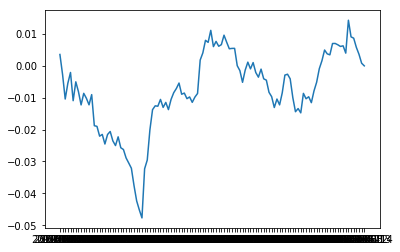

In [42]:
a=[str(i)[0:10] for i in instance.reg_result[5].index]
b=[i for i in instance.reg_result[1].values]
import matplotlib.pyplot as plt
plt.plot(a,b)
plt.show()

In [ ]:
##bar

In [ ]:
## other charts